In [1]:
# !add-apt-repository ppa:ubuntugis/ubuntugis-unstable -y
# !apt-get update
# !apt-get install python-numpy gdal-bin libgdal-dev python3-rtree

# !pip install rasterio
# !pip install geopandas
# !pip install descartes
# !pip install solaris # dont install it. 
# !pip install rio-tiler
# !pip install pystac

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [3]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
# import solaris as sol
from pathlib import Path
import rasterio
from rasterio.windows import Window
import geopandas as gpd
from pystac import (Catalog, CatalogType, Item, Asset, LabelItem, Collection)
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from rio_tiler import main as rt_main
import skimage
from tqdm import tqdm
import os
# os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"

# # We have to add this wrkaround for stackio:
# # (https://pystac.readthedocs.io/en/latest/concepts.html#using-stac-io)
# from urllib.parse import urlparse
# import requests
# from pystac import STAC_IO
# def my_read_method(uri):
#     parsed = urlparse(uri)
#     if parsed.scheme.startswith('http'):
#         return requests.get(uri).text
#     else:
#         return STAC_IO.default_read_text_method(uri)
# STAC_IO.read_text_method = my_read_method

In [4]:
from src.slicer import geojson_to_squares
from src.slicer import cleanup_invalid_geoms

In [5]:
# TIFF_PATH = "/home/zakirov/datasets/opencities/train_tier_1/acc/d41d81/d41d81.tif"
# GEOJSON_PATH = "/home/zakirov/datasets/opencities/train_tier_1/acc/d41d81-labels/d41d81.geojson"
area_code = "acc" # "znz"
area_id = "d41d81" #"3b20d4"
TIFF_PATH = f"/home/zakirov/datasets/opencities/train_tier_1/{area_code}/{area_id}/{area_id}.tif"
GEOJSON_PATH = f"/home/zakirov/datasets/opencities/train_tier_1/{area_code}/{area_id}-labels/{area_id}.geojson"
GEOJSON_TIFF_PATH = f"/home/zakirov/datasets/opencities/train_tier_1/{area_code}/{area_id}/{area_id}.json"

In [6]:
label_df = gpd.read_file(GEOJSON_PATH)
label_df = label_df[label_df['geometry'].isna() != True] # remove empty rows

In [7]:
gpd.read_file(GEOJSON_TIFF_PATH)

,id,area,license,datetime,geometry
0,d41d81,acc,CC BY 4.0,2019-07-07T00:00:00,"POLYGON ((-0.20863 5.58212, -0.20386 5.57954, ..."


In [8]:
# label_df.plot(figsize=(10,10));

In [9]:
ZOOM_LEVEL=19
TILE_SIZE=512

In [10]:
# !cat $GEOJSON_PATH | supermercado burn {ZOOM_LEVEL} | mercantile shapes | fio collect > trn_aoi_z{ZOOM_LEVEL}tiles.geojson

In [11]:
tiles_gdf = geojson_to_squares(GEOJSON_TIFF_PATH, ZOOM_LEVEL, val_percent=0.15)

In [12]:
tiles_gdf.head(1)

,id,title,geometry,xyz,dataset
0,"(261867, 253985, 19)","XYZ tile (261867, 253985, 19)","POLYGON ((-0.19020 5.59275, -0.19020 5.59343, ...","[261867, 253985, 19]",train


In [13]:
tiles_gdf.dataset.value_counts()

train    363
val       65
Name: dataset, dtype: int64

In [14]:
tiles_gdf.dataset.value_counts()

train    363
val       65
Name: dataset, dtype: int64

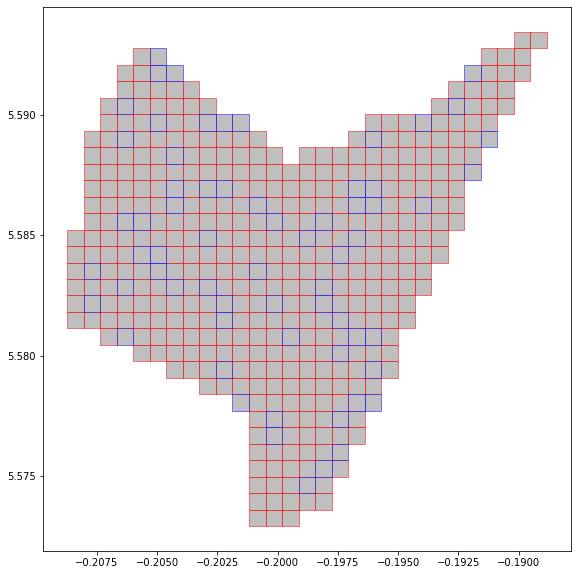

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
tiles_gdf[tiles_gdf.dataset == "train"].plot(ax=ax, figsize=(10,10), color='grey', alpha=0.5, edgecolor='red');
tiles_gdf[tiles_gdf.dataset == "val"].plot(ax=ax, figsize=(10,10), color='grey', alpha=0.5, edgecolor='blue');

In [16]:
from rio_tiler import main as rt_main

# import mercantile
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

In [17]:
all_polys = label_df.geometry
# all_polys.head(3)

In [18]:
all_polys = cleanup_invalid_geoms(all_polys)

In [19]:
import rio_tiler

In [51]:
idx = np.random.randint(0, len(tiles_gdf))
# idx=5
tiles_gdf.iloc[idx]['xyz']
tile, mask = rt_main.tile(TIFF_PATH, *tiles_gdf.iloc[idx]['xyz'], tilesize=TILE_SIZE)
# plt.figure(figsize=(7, 7))
# plt.imshow(np.moveaxis(tile,0,2));

(-0.199127197265625, 5.57429999992256, -0.1984405517578125, 5.574983397934478)


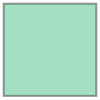

In [52]:
# get the same tile polygon as our tile image above
tile_poly = tiles_gdf.iloc[idx]['geometry']
print(tile_poly.bounds)
tile_poly

In [53]:
# get affine transformation matrix for this tile using rasterio.transform.from_bounds: https://rasterio.readthedocs.io/en/stable/api/rasterio.transform.html#rasterio.transform.from_bounds
tfm = from_bounds(*tile_poly.bounds, TILE_SIZE, TILE_SIZE) 
# tfm

In [54]:
# crop geometries to what overlaps our tile polygon bounds
cropped_polys = [poly for poly in all_polys if poly.intersects(tile_poly)]
cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs=4326)
# cropped_polys_gdf.plot()

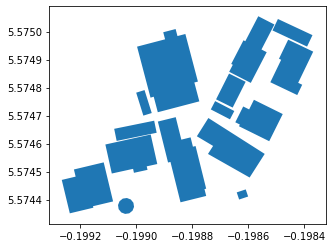

In [55]:
cropped_polys_gdf.plot()

In [56]:
df = cropped_polys_gdf
feature_list = list(zip(df["geometry"], [255]*len(df)))

In [57]:
if len(feature_list) > 0:
    im = rasterio.features.rasterize(shapes=feature_list, out_shape=(TILE_SIZE,TILE_SIZE), transform=tfm)
else:
    im = np.zeros((TILE_SIZE, TILE_SIZE), np.uint8)

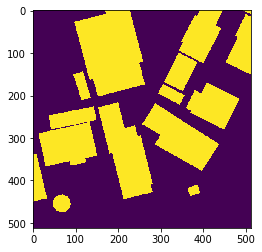

In [58]:
plt.imshow(im)

In [59]:
# burn a footprint/boundary/contact 3-channel mask with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html
# we're only using it 
# fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
#                                          channels=['footprint', 'boundary', 'contact'],
#                                          affine_obj=tfm, shape=(TILE_SIZE,TILE_SIZE),
#                                          boundary_width=7, boundary_type='inner', contact_spacing=5, meters=True)

In [60]:
# np.unique(fbc_mask[0])

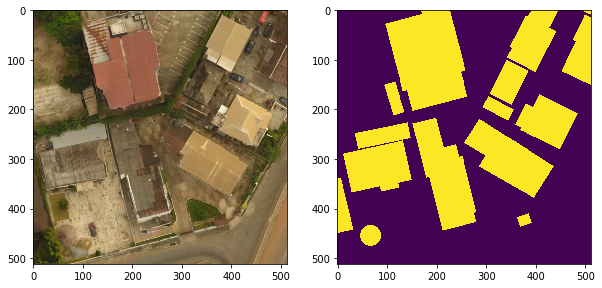

In [98]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
img = np.moveaxis(tile,0,2)
ax1.imshow(img)
ax2.imshow(im)

In [62]:
# fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10, 5))
# ax1.imshow(fbc_mask[:,:,0])
# ax2.imshow(fbc_mask[:,:,1])
# ax3.imshow(fbc_mask[:,:,2])

# Test distance transform 

# Inria dataset

In [8]:
import cv2
import numpy as np
import pandas as pd
import albumentations as albu
from torch.utils.data import Dataset

class InriaTilesDataset(Dataset):

    def __init__(self, split="all", transform=None):
        super().__init__()
        df = pd.read_csv("/home/zakirov/datasets/AerialImageDataset/inria_tiles.csv", index_col=0)
        if split == "val":
            df = df[df.train == 0]
        elif split == "train":
            df = df[df.train == 1]
        self.img_ids = df["image"].values
        self.mask_ids = df["mask"].values
        self.transform = albu.Compose([]) if transform is None else transform
    
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_ids[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_ids[idx], cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, 2)
        augmented = self.transform(image=img, mask=mask)
        aug_img, aug_mask = augmented['image'], augmented['mask'] / 255.
        print(aug_img.shape, aug_mask.shape)
        return aug_img, aug_mask

In [9]:
aug = albu.Compose([
    albu.RandomResizedCrop(384, 384, scale=(0.1, 0.7)),
])
ds = InriaTilesDataset("val", transform=aug)

In [12]:
np.unique(ds[N][1])

(768, 768, 3) (768, 768, 1)


array([0., 1.])

In [11]:
ds = InriaTilesDataset("val")
N = 10
plt.imshow(ds[N][0])
plt.show()
plt.imshow(ds[N][1].squeeze())

NameError: name 'plt' is not defined

In [31]:
df[df.train == 0]["mask"].values

array(['/home/zakirov/datasets/AerialImageDataset/train_tiles/gt/austin1_tile_0.png',
       '/home/zakirov/datasets/AerialImageDataset/train_tiles/gt/austin1_tile_1.png',
       '/home/zakirov/datasets/AerialImageDataset/train_tiles/gt/austin1_tile_2.png',
       ...,
       '/home/zakirov/datasets/AerialImageDataset/train_tiles/gt/vienna5_tile_46.png',
       '/home/zakirov/datasets/AerialImageDataset/train_tiles/gt/vienna5_tile_47.png',
       '/home/zakirov/datasets/AerialImageDataset/train_tiles/gt/vienna5_tile_48.png'],
      dtype=object)

In [10]:
df.head()

,image,train,image_id,mask,has_buildings
0,/home/zakirov/datasets/AerialImageDataset/trai...,1,austin6,/home/zakirov/datasets/AerialImageDataset/trai...,True
1,/home/zakirov/datasets/AerialImageDataset/trai...,1,austin6,/home/zakirov/datasets/AerialImageDataset/trai...,True
2,/home/zakirov/datasets/AerialImageDataset/trai...,1,austin6,/home/zakirov/datasets/AerialImageDataset/trai...,False
3,/home/zakirov/datasets/AerialImageDataset/trai...,1,austin6,/home/zakirov/datasets/AerialImageDataset/trai...,True
4,/home/zakirov/datasets/AerialImageDataset/trai...,1,austin6,/home/zakirov/datasets/AerialImageDataset/trai...,True
